# **Практика 2: Исследование атак на модели ИИ. FastGradient Sign Method (FGSM)**

По предмету: **Анализ защищенности систем искусственного интеллекта**

Выполнил студент **2 курса** группы **ББМО-02-23**

**Карпейкин Владислав Анатольевич**

# **Цель задания:**
Познакомиться с одной из популярных атак на системы машинного обучения — атакой Fast Gradient
Sign Method (FGSM). Задача — научиться использовать FGSM для создания противоречивых (adversarial)
примеров, которые могут ввести обученную модель в заблуждение.


# **Задачи:**
1. Загрузить ранее обученную модель на датасете MNIST;
2. Изучить теоретические основы FGSM;
3. Реализовать атаку FGSM и сгенерировать противоречивые примеры;
4. Оценить точность модели на противоречивых примерах и сравнить с результатами на обычных данных.


# **Шаги выполнения:**

## **1. Загрузка обученной модели и данных MNIST:**

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0

# Преобразование меток в категориальный формат
test_labels = to_categorical(test_labels, num_classes=10)

# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images.reshape(-1, 28, 28, 1), test_labels)  # Обратите внимание на изменение формы
print(f'Test accuracy on clean images: {test_acc:.4f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9713 - loss: 0.0929
Test accuracy on clean images: 0.9757


## **2. Теория FGSM:**
Атака Fast Gradient Sign Method (FGSM) — это метод генерации противоречивых примеров, который изменяет пиксели изображения на минимальные величины, направленные на ухудшение предсказаний модели. FGSM использует градиент потерь по отношению к входному изображению и добавляет небольшие изменения, чтобы максимизировать ошибку предсказания.

Формула атаки:

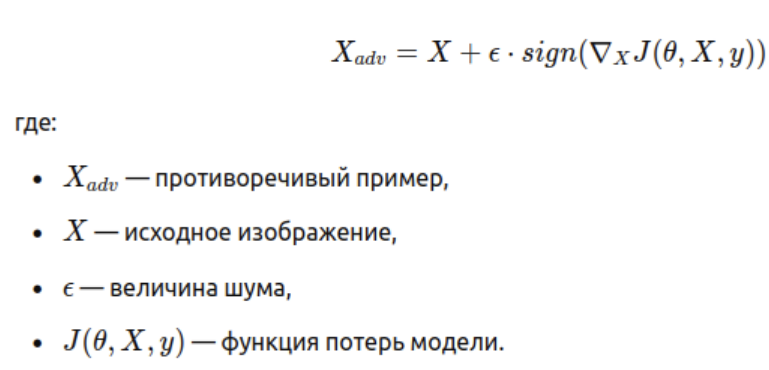


## **3. Реализация атаки FGSM:**

Теперь реализуем FGSM для генерации противоречивых примеров

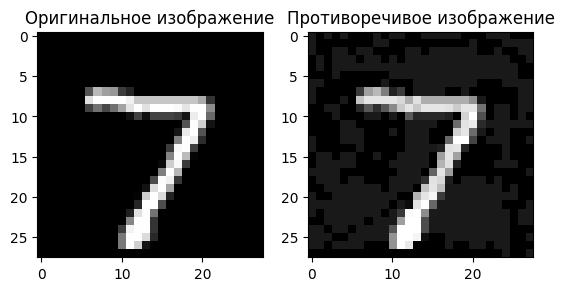

In [4]:
import numpy as np
# Функция для реализации FGSM атаки
def fgsm_attack(image, epsilon, gradient):
 # Применение знака градиента к изображению
 perturbed_image = image + epsilon * np.sign(gradient)
 # Обрезка значений, чтобы они оставались в пределах [0,1]
 perturbed_image = np.clip(perturbed_image, 0, 1)
 return perturbed_image
# Вычисление градиента
def generate_adversarial_example(model, image, label, epsilon):
  # Превращение изображения в формат, подходящий для модели
  image = tf.convert_to_tensor(image.reshape((1, 28, 28, 1)))
  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = model(image)
    loss = tf.keras.losses.categorical_crossentropy(label[None], prediction)
  # Получение градиента по отношению к входному изображению
  gradient = tape.gradient(loss, image)
  # Применение FGSM
  adversarial_image = fgsm_attack(image.numpy(), epsilon, gradient.numpy())

  return adversarial_image
# Пример использования
epsilon = 0.1 # Величина шума
adversarial_example = generate_adversarial_example(model, test_images[0],
test_labels[0], epsilon)
# Вывод результатов
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(test_images[0], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение")
plt.imshow(adversarial_example.reshape(28, 28), cmap="gray")
plt.show()


## **4. Оценка модели на противоречивых примерах:**

Теперь мы проверим точность модели на противоречивых изображениях, сгенерированных при
помощи FGSM.

In [5]:
# Генерация противоречивых примеров для всего набора данных
def generate_adversarial_dataset(model, images, labels, epsilon):
    adversarial_images = []
    for i in range(len(images)):
        # Генерация противоречивого изображения
        adv_image = generate_adversarial_example(model, images[i], labels[i], epsilon)
        adversarial_images.append(adv_image)

    return np.array(adversarial_images)

# Генерация противоречивых примеров
adversarial_images = generate_adversarial_dataset(model, test_images, test_labels, epsilon)

# Оценка модели на противоречивых примерах
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images.reshape(-1, 28, 28, 1), test_labels)
print(f'Точность на противоречивых примерах: {adversarial_acc:.4f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0963 - loss: 6.8058
Точность на противоречивых примерах: 0.1185


## 5. Сравнение результатов:


In [6]:
print(f'Точность на чистых изображениях: {test_acc:.4f}')
print(f'Точность на противоречивых примерах: {adversarial_acc:.4f}')

Точность на чистых изображениях: 0.9757
Точность на противоречивых примерах: 0.1185


## **6. Вывод:**
Разница в точности модели между обычными и противоречивыми примерами поразительна. Точность на обычных примерах достигает примерно 97,6%, в то время как на противоречивых она составляет всего 11,9%. Это свидетельствует о том, что модель подвержена атакам, что является распространенной проблемой в области машинного обучения.

Такое значительное снижение точности указывает на то, что модель не справляется с задачей распознавания в условиях небольших, но целенаправленных искажений. Это подчеркивает необходимость разработки более устойчивых моделей и внедрения методов защиты от атак для повышения надежности в реальных приложениях.